In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

In [18]:
# H7.1: Training data

p = 60 # samples per class

# mean, variance
mu_1 = np.array([0,1])
mu_2 = np.array([1,0])
mu_3 = np.array([0,0])
mu_4 = np.array([1,1])
var = 0.1
cov = var * np.eye(2)

class_0 = []
for _ in range(p):
  if np.random.rand() < 0.5:
    x = np.random.multivariate_normal(mu_1, cov)
  else:
    x = np.random.multivariate_normal(mu_2, cov)
  class_0.append(x)

class_1 = []
for _ in range(p):
  if np.random.rand() < 0.5:
    x = np.random.multivariate_normal(mu_3, cov)
  else:
    x = np.random.multivariate_normal(mu_4, cov)
  class_1.append(x)

X = np.vstack((class_0, class_1)) # shape: (120, 2)
y = np.array([0]*p + [1]*p) # shape: (120,)

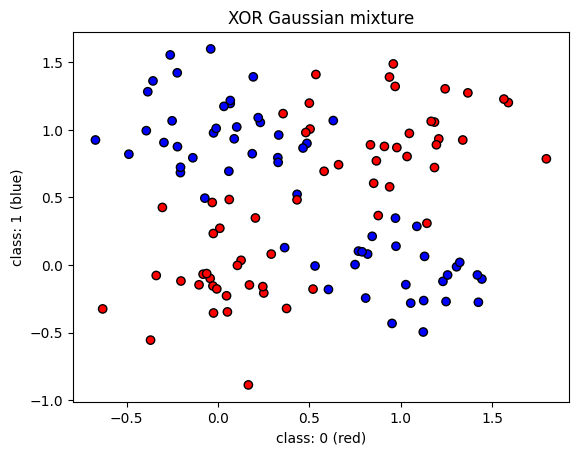

In [19]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
plt.title("XOR Gaussian mixture")
plt.xlabel("class: 0 (red)")
plt.ylabel("class: 1 (blue)")
plt.show()

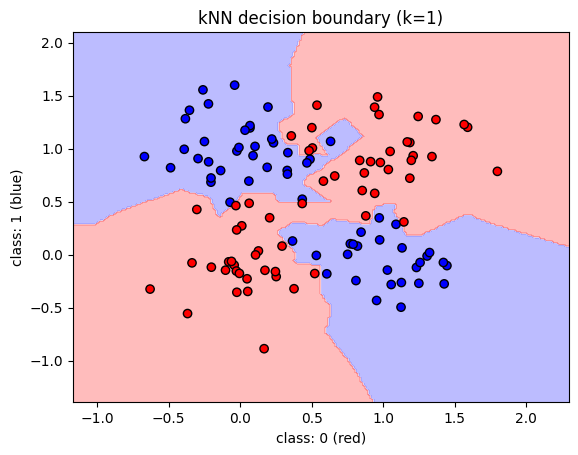

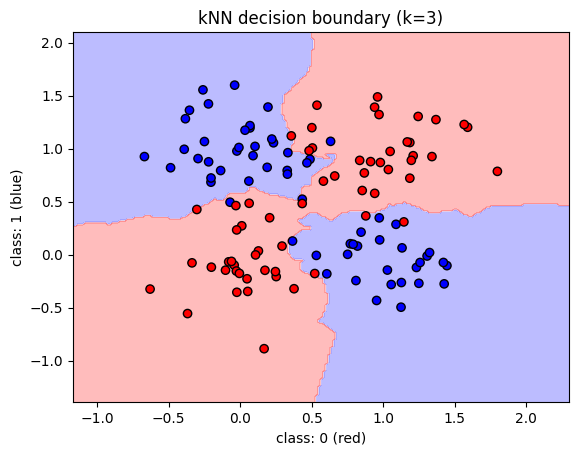

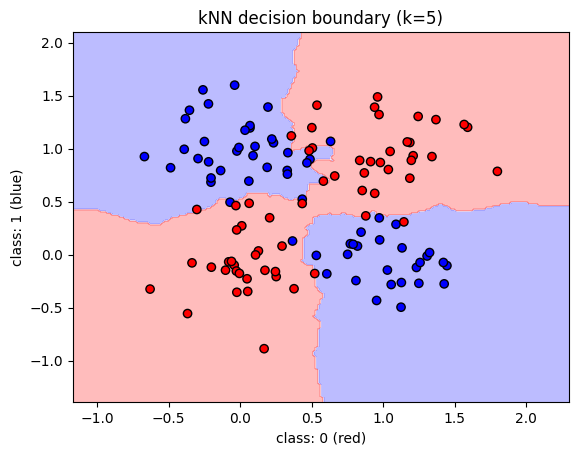

In [20]:
# H7.2: k nearest neighbors (kNN)

# k for k nearest neighbors
# if k even: knn selects smaller labels, e.g. 0 instead of 1
k_set = [1, 3, 5]

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# grid points are (kind of) virtual test samples
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200)) # xx.shape: (200, 200)

grid_points = np.c_[xx.ravel(), yy.ravel()] # shape: (40000, 2)

# 120 samples are the candidates of neighbors
# we search k nearest neighbors among 120 samples for every grid_points

for k in k_set:
  knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='euclidean')
  knn.fit(X, y)
  Z = knn.predict(grid_points)
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')  # Decision boundary
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')  # Training data
  plt.title(f"kNN decision boundary (k={k})")
  plt.xlabel("class: 0 (red)")
  plt.ylabel("class: 1 (blue)")
  plt.show()

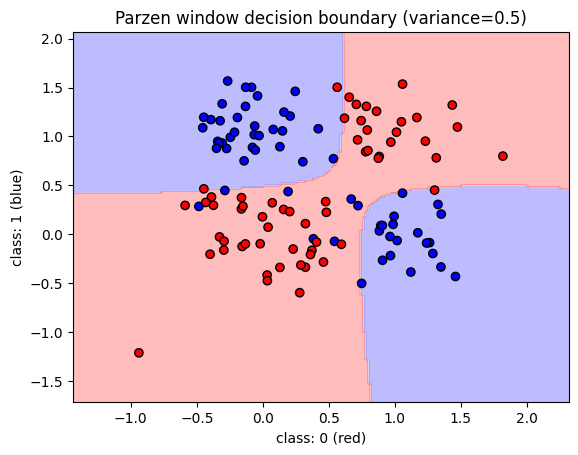

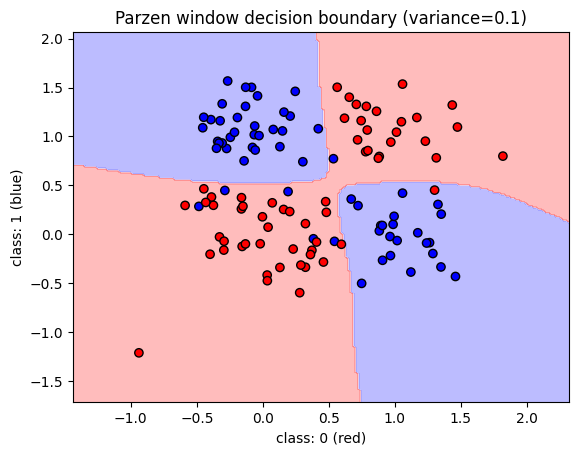

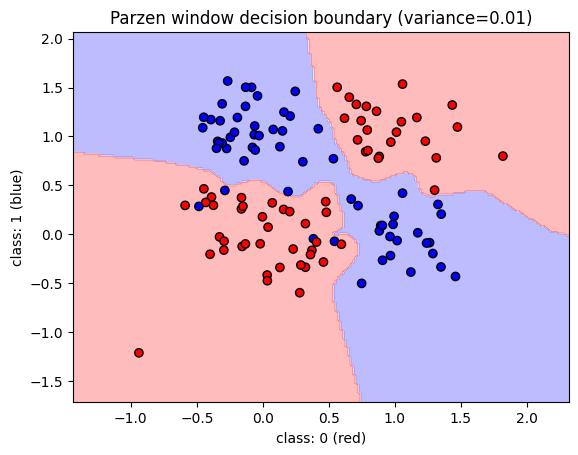

In [5]:
# H7.3: Parzen window classifier
# (a)

# define function: Parzen window (Gaussian window function based on Euclidean norm)
def gaussian_window(query, samples, var):
  diff = query - samples
  return np.exp(-np.sum(diff**2, axis=1)/(2*var))

# modified to use in H7.3 (b) - for three classes
def parzen_classify(query, samples, labels, var):
  kernel_val = gaussian_window(query, samples, var)
  # w_class_0 = np.sum(kernel_val[labels == 0])
  # w_class_1 = np.sum(kernel_val[labels == 1])
  unique_classes = np.unique(labels)
  weights = []

  for c in unique_classes:
    weights.append(np.sum(kernel_val[labels == c]))

  # higher estimated density: (kind of) maximum likelihood classification
  # return 0 if w_class_0 > w_class_1 else 1
  return unique_classes[np.argmax(weights)]

# list of variances
vars = [0.5, 0.1, 0.01]

for var in vars:
  preds = []

  for point in grid_points:
    pred = parzen_classify(point, X, y, var)
    preds.append(pred)

  # reshape preds for meshgrid contour plotting
  Z = np.array(preds).reshape(xx.shape)

  plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')  # Decision boundary
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')  # Training data
  plt.title(f"Parzen window decision boundary (variance={var})")
  plt.xlabel("class: 0 (red)")
  plt.ylabel("class: 1 (blue)")
  plt.show()

In [6]:
# H7.3 (b)
# add 60 new samples for 'class: 2'
mu_5 = np.array([0.5, 0.5])
var_new = 0.05
cov_5 = var_new * np.eye(2)
class_2 = np.random.multivariate_normal(mu_5, cov_5, p)

X_new = np.vstack((X, class_2)) # shape: (180, 2)
y_new = np.hstack((y, np.full(60, 2))) # shape: (180,), labels: [0, 1, 2]

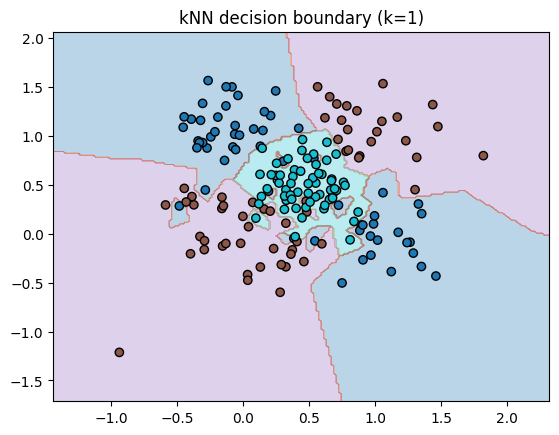

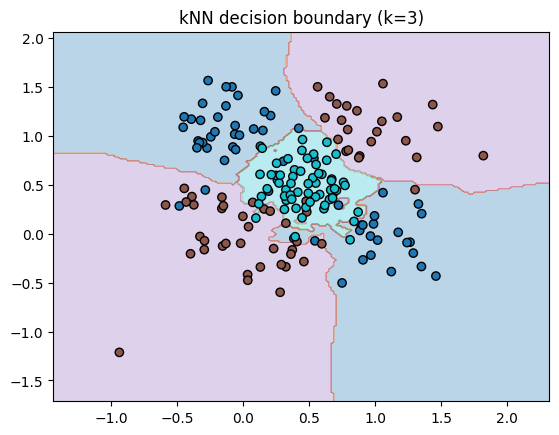

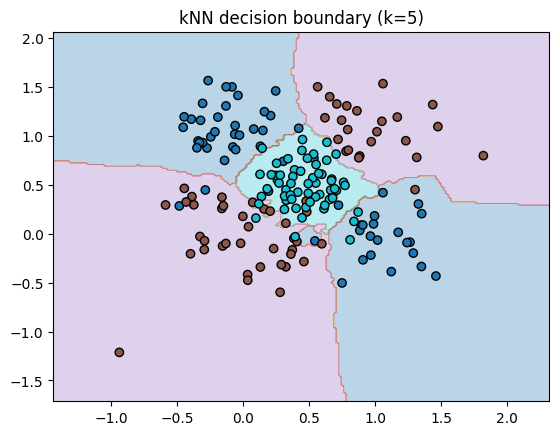

In [7]:
# apply kNN to three classes

for k in k_set:
  knn = KNeighborsClassifier(n_neighbors=k, p=2, metric='euclidean')
  knn.fit(X_new, y_new)
  Z_new = knn.predict(grid_points)
  Z_new = Z_new.reshape(xx.shape)
  plt.contourf(xx, yy, Z_new, alpha=0.3, cmap='tab10')  # Decision boundary
  plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, cmap='tab10', edgecolor='k')  # Training data
  plt.title(f"kNN decision boundary (k={k})")
  plt.show()

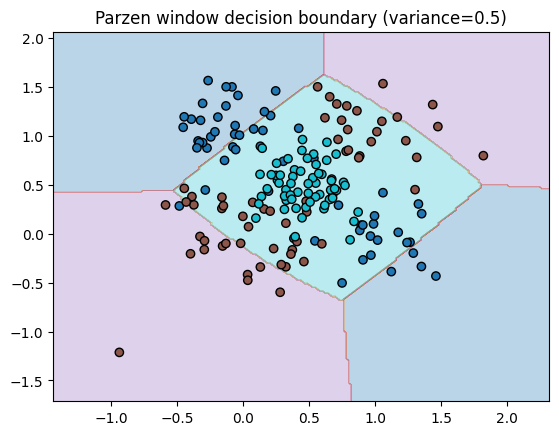

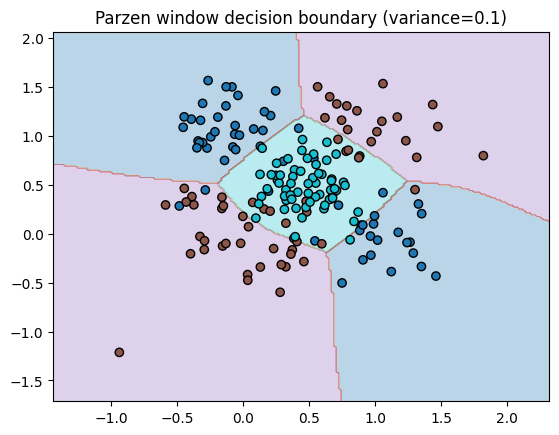

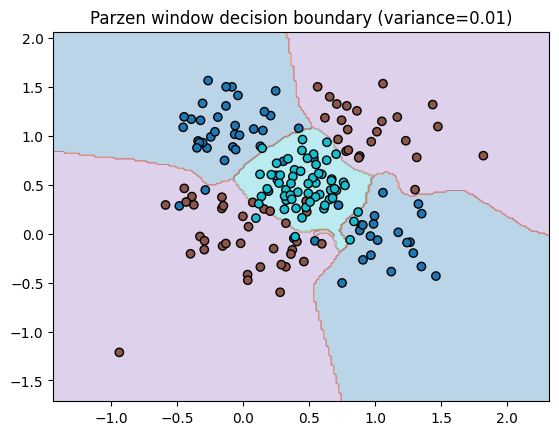

In [8]:
# apply Parzen-window classification to three classes

for var in vars:
  preds = []

  for point in grid_points:
    pred = parzen_classify(point, X_new, y_new, var)
    preds.append(pred)

  # reshape preds for meshgrid contour plotting
  Z_new = np.array(preds).reshape(xx.shape)

  plt.contourf(xx, yy, Z_new, alpha=0.3, cmap='tab10')  # Decision boundary
  plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, cmap='tab10', edgecolor='k')  # Training data
  plt.title(f"Parzen window decision boundary (variance={var})")
  plt.show()

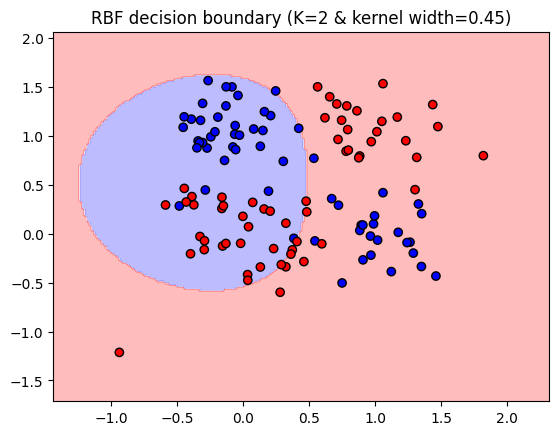

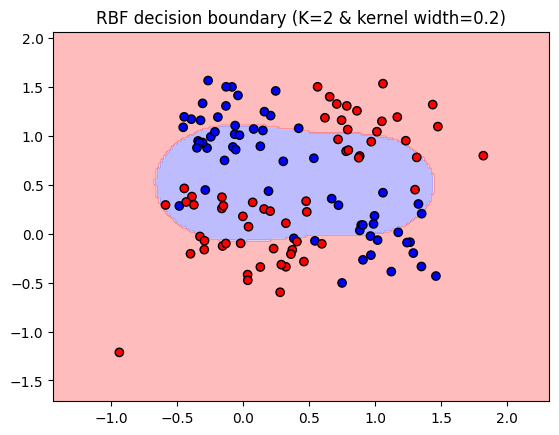

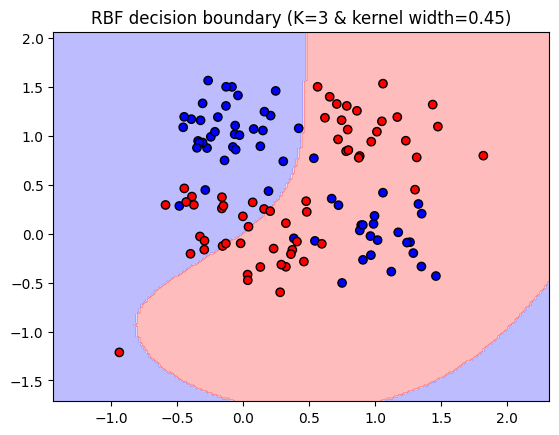

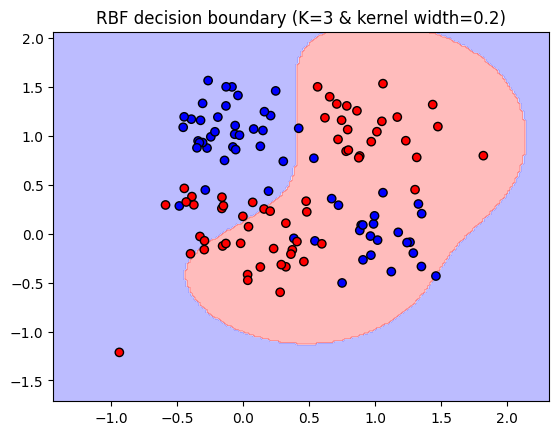

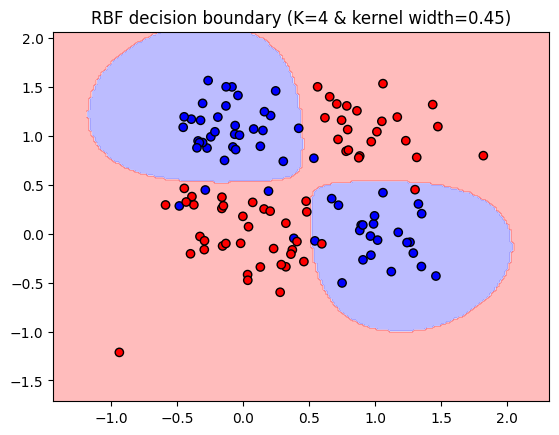

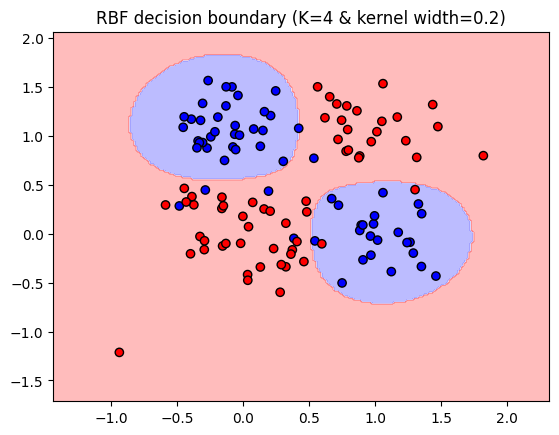

In [9]:
# H7.4: RBF networks
# (a)

# list of k for K-means clustering
K_set = [2, 3, 4]
kernel_widths = [0.45, 0.2]

# step function converting output to the class prediction
def step(h):
  return (h >= 0.5).astype(int)

def gaussian_rbf_window(query, centers, var):
  # query shape: (n_grid, 2) for grid_points
  # center shape: (K, 2)
  diff = query[:, np.newaxis, :] - centers[np.newaxis, :, :] # shape: (n_sample, K, 2)
  return np.exp(-np.sum(diff**2, axis=2)/(2*var)) # shape: (n_sample, K)

# define phi function
def phi(x, centers, width):
  phi_basis = gaussian_rbf_window(x, centers, width)
  phi_x = np.hstack([np.ones((x.shape[0], 1)), phi_basis]) # shape: (n_x, K+1)

  return phi_x.T # shape: (K+1, n_x)

def pred_class(x, w, centers, width):
  return step(w.T @ phi(x, centers, width))

y_T = y.reshape(1, -1) # shape: (1, 120)

for k in K_set:
  for width in kernel_widths:
    # K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    centers = kmeans.cluster_centers_ # shape: (K, 2)

    # Phi using phi function
    Phi_train = phi(X, centers, width) # shape: (K+1, n_sample=120)
    Phi_grid = phi(grid_points, centers, width) # shape: (K+1, n_grid=40000)

    # pinv instead of inv to compute Moore-Penrose pseudo-inverse (including singular problem)
    w = np.linalg.pinv(Phi_train @ Phi_train.T) @ Phi_train @ y_T.T

    y_pred = pred_class(x=grid_points, w=w, centers=centers, width=width).flatten()
    Z_rbf = np.array(y_pred).reshape(xx.shape)

    plt.contourf(xx, yy, Z_rbf, alpha=0.3, cmap='bwr')  # Decision boundary
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')  # Training data
    plt.title(f"RBF decision boundary (K={k} & kernel width={width})")
    plt.show()

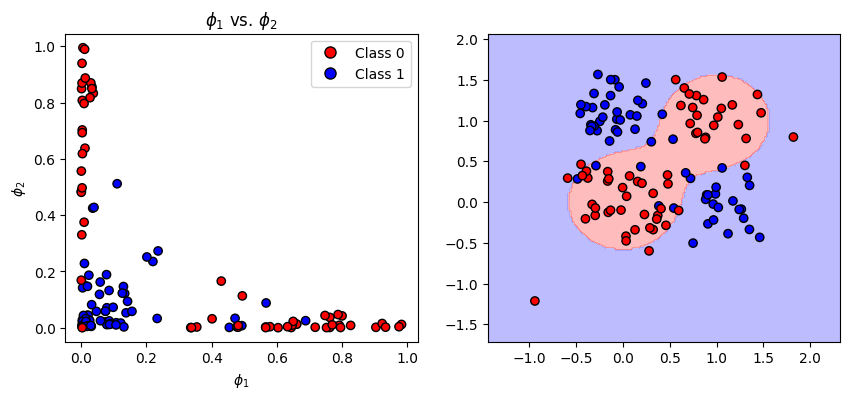

In [10]:
# (b)

centers_t = np.array([[0, 0], [1, 1]]) # K=2
width_k = 0.2

# Phi using phi function
Phi_train = phi(X, centers_t, width_k) # shape: (3, n_sample=120)
Phi_grid = phi(grid_points, centers_t, width_k) # shape: (3, n_grid=40000)

phi1 = Phi_train[1]
phi2 = Phi_train[2]

# pinv instead of inv to compute Moore-Penrose pseudo-inverse (including singular problem)
w0 = np.linalg.pinv(Phi_train @ Phi_train.T) @ Phi_train @ y_T.T

y_pred_0 = pred_class(x=grid_points, w=w0, centers=centers_t, width=width_k).flatten()

Z_0 = np.array(y_pred_0).reshape(xx.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(phi1, phi2, c=y, cmap='bwr', edgecolors='k')
ax[0].set_title("$\phi_{1}$ vs. $\phi_{2}$")
ax[0].set_xlabel("$\phi_{1}$")
ax[0].set_ylabel("$\phi_{2}$")

# Make a simple legend manually:
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Class 0',
                       markerfacecolor='red', markersize=8, markeredgecolor='k')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Class 1',
                        markerfacecolor='blue', markersize=8, markeredgecolor='k')
ax[0].legend(handles=[red_patch, blue_patch], loc='best')

ax[1].contourf(xx, yy, Z_0, alpha=0.3, cmap='bwr')
ax[1].scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')  # Training data

plt.show()